In [197]:
#!pip install petrofit #install petrofit, one time only


In [149]:
from astropy.nddata import CCDData

image = CCDData.read('NGC7332/frame-i-004836-6-0240.fits.bz2')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


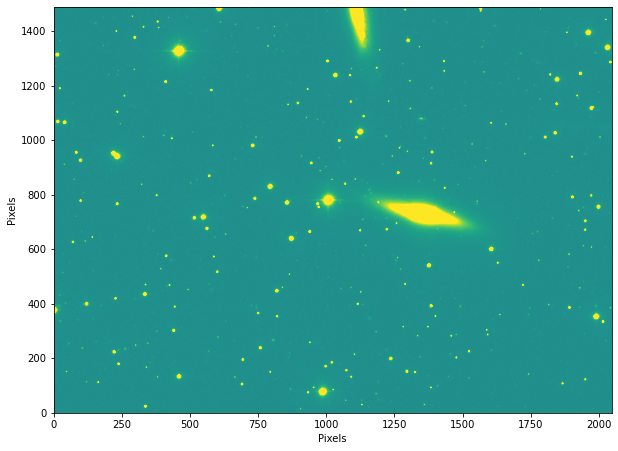

In [150]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['image.origin'] = 'lower'

vmax = image.data.std() # Use the image std as max and min of all plots
vmin = - vmax

plt.imshow(image.data, vmin=vmin, vmax=vmax)
#plt.title("Galaxy in Abell 2744")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

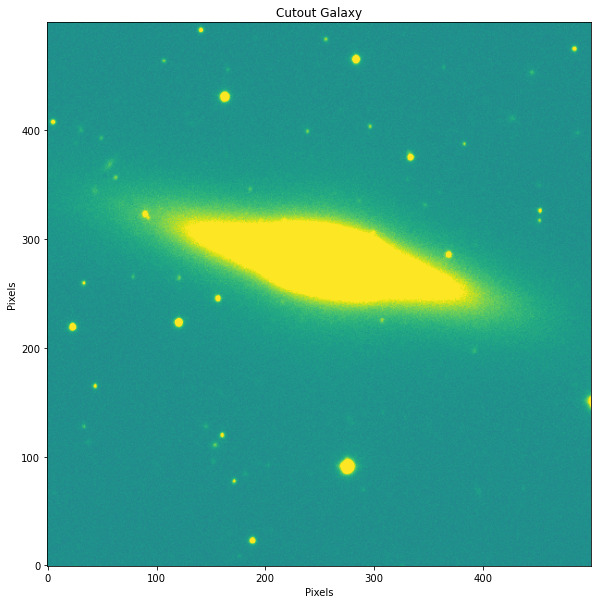

In [153]:
from astropy.nddata import Cutout2D

cutout_image = Cutout2D(image, position=(1350,700), size=500)


plt.imshow(cutout_image.data, vmin=vmin, vmax=vmax)
plt.title("Cutout Galaxy")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

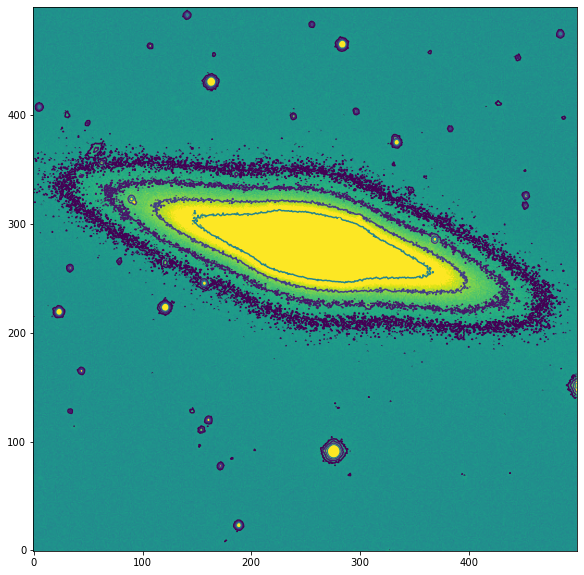

In [154]:
ax = plt.subplot()
ax.imshow(cutout_image.data, vmin=vmin, vmax=vmax) #original image
ax.contour(cutout_image.data, levels=np.logspace(-0.8, 0.5, 5))#, colors='white', alpha=0.5)

-0.00021878205 0.11718843877315521 0.31250250339508057


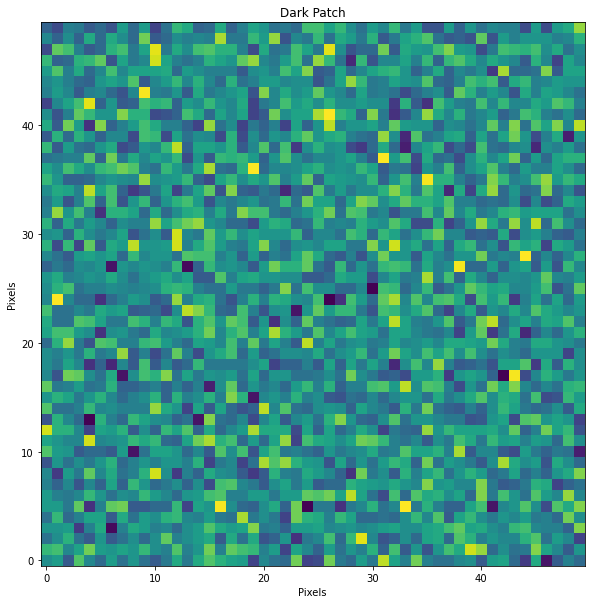

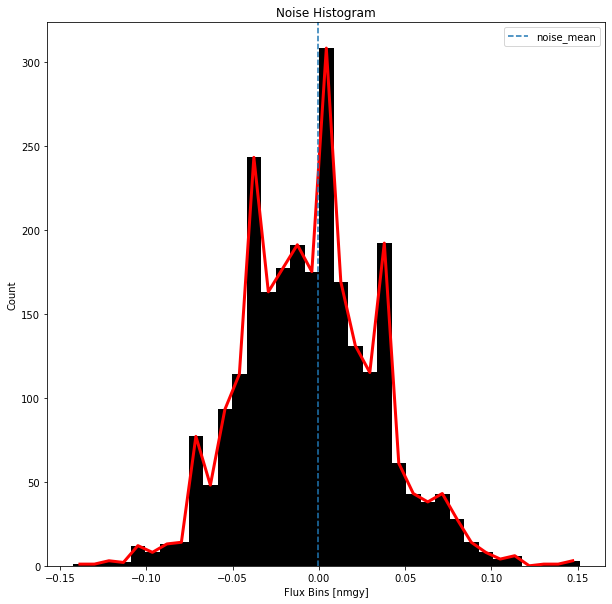

In [155]:
from astropy.nddata import Cutout2D

# Estimate data noise at dark area
# --------------------------------
noise_cutout_pos = (50, 50)
noise_cutout_size = 50
noise_cutout = Cutout2D(image, noise_cutout_pos, noise_cutout_size)

noise_mean = noise_cutout.data.mean()
noise_sigma = noise_cutout.data.std()
noise_3_sigma = noise_sigma * 3.
noise_8_sigma = noise_sigma * 8.

print(noise_mean, noise_3_sigma, noise_8_sigma)

# Plot image and noise distribution
# ---------------------------------
plt.imshow(noise_cutout.data, vmax=noise_mean+noise_3_sigma, vmin=noise_mean-noise_3_sigma)
plt.title("Dark Patch")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

n, bins, patches = plt.hist(noise_cutout.data.flatten(), bins=35, align='left', color='black')
plt.plot(bins[:-1], n, c='r', linewidth=3)
plt.axvline(noise_mean, label="noise_mean", linestyle="--")

plt.xlabel('Flux Bins [{}]'.format(str(image.unit)))
plt.ylabel('Count')
plt.title('Noise Histogram')
plt.legend()

plt.show()

In [156]:
from astropy.stats import sigma_clipped_stats
image_mean, image_median, image_stddev = sigma_clipped_stats(image.data, sigma=3)

In [157]:
# Define detect threshold
threshold = noise_8_sigma

In [132]:
kernel_size = 7
fwhm = 3
#sigma = fwhm * gaussian_fwhm_to_sigma
#kernel = Gaussian2DKernel(sigma, x_size=kernel_size, y_size=kernel_size)

In [158]:
npixels = 10**2

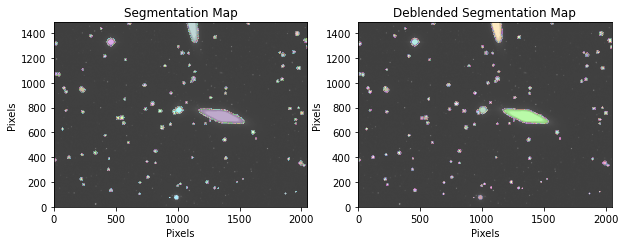

In [162]:
from petrofit.segmentation import make_catalog, plot_segments

cat, segm, segm_deblend = make_catalog(
    image.data,
    threshold,
    deblend=True,
    kernel_size=kernel_size,
    fwhm=fwhm,
    npixels=npixels,
    plot=True, vmax=vmax, vmin=vmin
)

In [163]:
# Display source properties
print("Num of Targets:", len(cat))

# Convert to table
cat_table = cat.to_table()

cat_table[:10]

Num of Targets: 102


label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int32,float64,float64,object,int32,int32,int32,int32,float64,float64,float64,float64,float64,float32,float32,float64,float32,float64,float64,float64
1,335.233245133843,24.281630532958857,None,326,345,15,34,312.0,2.2235086319621797,2.1701053446273235,73.83384432772503,0.21784927782757035,-0.04937744,20.125,0.0,332.96652,nan,317.37281803475554,nan
2,985.3258697731048,77.81601515742888,None,964,1008,57,99,1463.0,5.572532909400526,5.105201787844083,11.870742353840189,0.400866046409359,0.099609375,86.75,0.0,4777.3345,nan,4651.0534421354005,nan
3,932.2859113232464,75.23817398734668,None,926,939,69,81,142.0,1.9999561990700523,1.9752339617385728,-58.91179706833111,0.1567481254250902,0.024597168,6.5859375,0.0,106.07208,nan,113.33235567650212,nan
4,689.6737183639739,105.86122829702923,None,681,698,97,115,273.0,2.1816847418911878,2.135498173313483,-84.45877116815524,0.20467560338354712,-0.05706787,17.75,0.0,265.03253,nan,253.82024885214418,nan
5,1866.0067150243024,108.32825110492576,None,1860,1872,102,115,137.0,1.9444729899744921,1.8259064399040026,-85.7130112593225,0.34385211935929433,-0.014678955,7.078125,0.0,113.51471,nan,113.25913573529425,nan
6,1949.6131024921735,122.98931711089034,None,1944,1955,117,129,115.0,1.9042976332639467,1.7558526455353738,-80.35060034574535,0.38707702987339476,0.03289795,6.328125,0.0,97.56128,nan,98.6228556551196,nan
7,458.56089526020247,134.0513207999218,None,444,473,120,148,677.0,2.537354684527225,2.5126006744034663,42.74463311818684,0.139343069220923,-0.00894165,149.75,0.0,2275.4456,nan,2129.9972198415107,nan
8,1294.9446932423352,152.80735336965284,None,1285,1305,143,163,349.0,2.27270431629559,2.2569946920092976,-86.139851704248,0.11737473773508014,-0.06384277,26.59375,0.0,410.49316,nan,390.2935691720665,nan


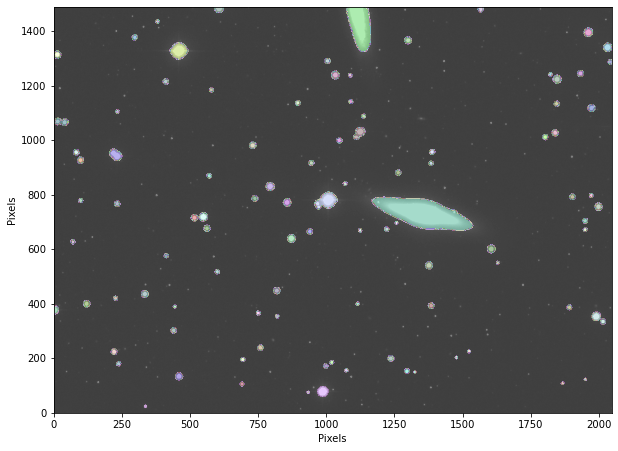

In [164]:
from petrofit.segmentation import plot_segments

plot_segments(segm, image=image.data, vmax=vmax, vmin=vmin)

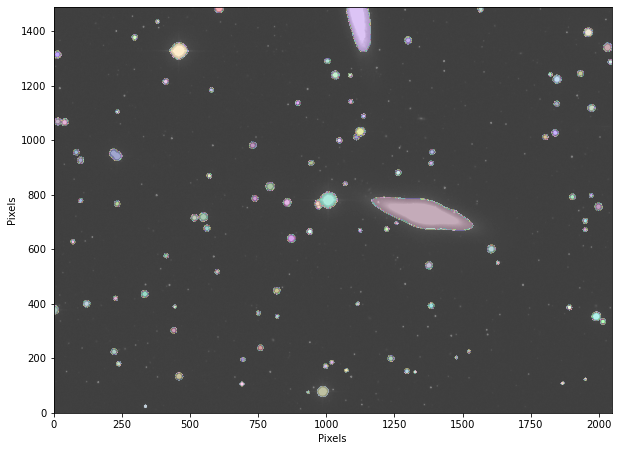

In [165]:
plot_segments(segm_deblend, image=image.data, vmax=vmax, vmin=vmin)

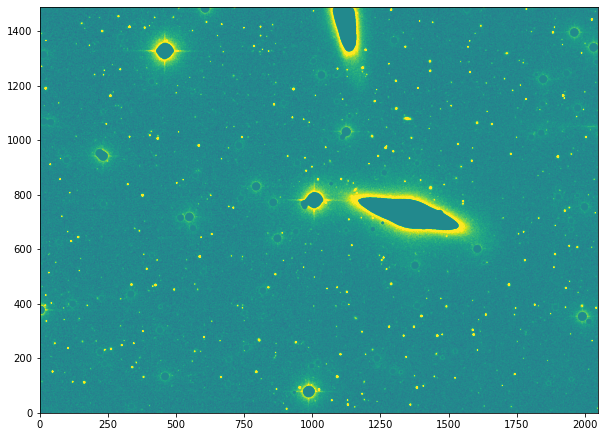

In [166]:
from petrofit.segmentation import plot_segment_residual
plot_segment_residual(segm, image.data, vmax=vmax/5)

In [167]:
from petrofit.photometry import order_cat

# Sort and get the largest object in the catalog
sorted_idx_list = order_cat(cat, key='area', reverse=True)
idx = sorted_idx_list[0] # index 0 is largest
source = cat[idx]  # get source from the catalog

In [186]:
from petrofit.photometry import make_radius_list

r_list = make_radius_list(
    max_pix=400, # Max pixel to go up to
    n=50 # the number of radii to produce
)

print(repr(r_list))

array([  8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.,  88.,
        96., 104., 112., 120., 128., 136., 144., 152., 160., 168., 176.,
       184., 192., 200., 208., 216., 224., 232., 240., 248., 256., 264.,
       272., 280., 288., 296., 304., 312., 320., 328., 336., 344., 352.,
       360., 368., 376., 384., 392., 400.])


46


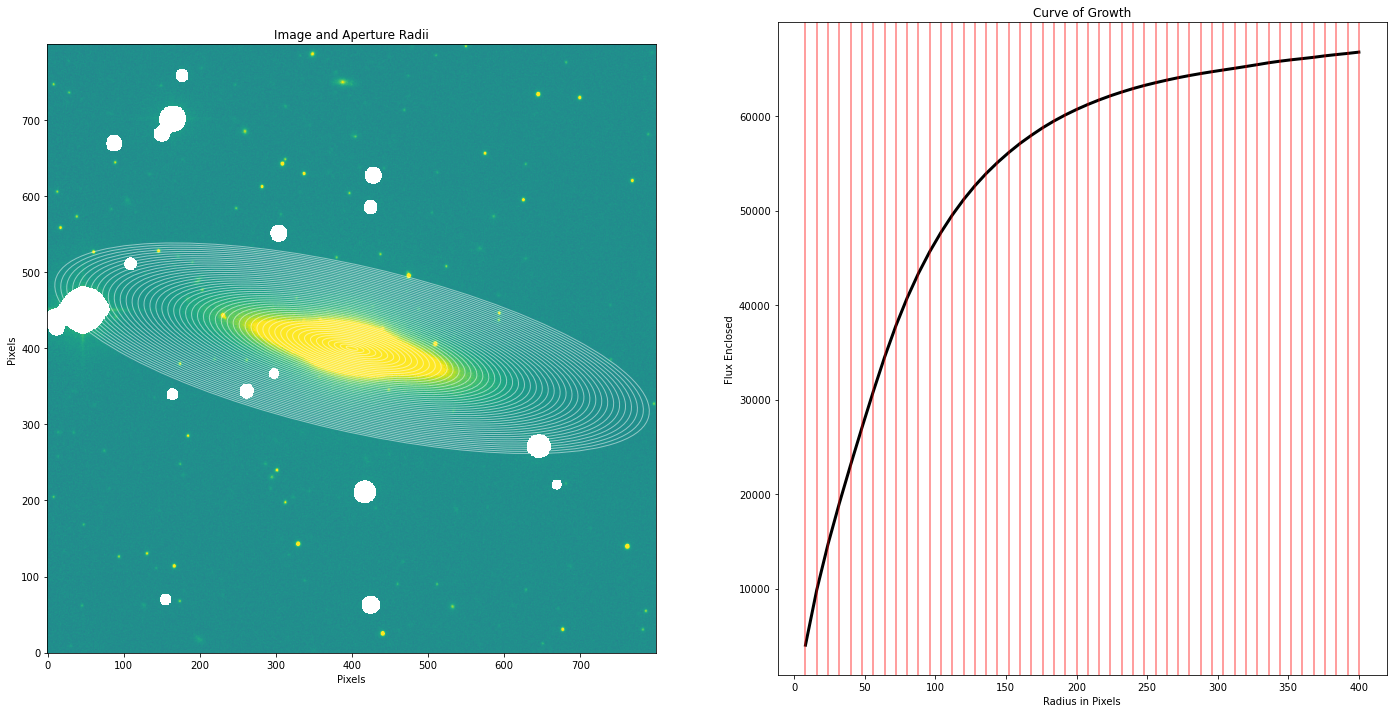

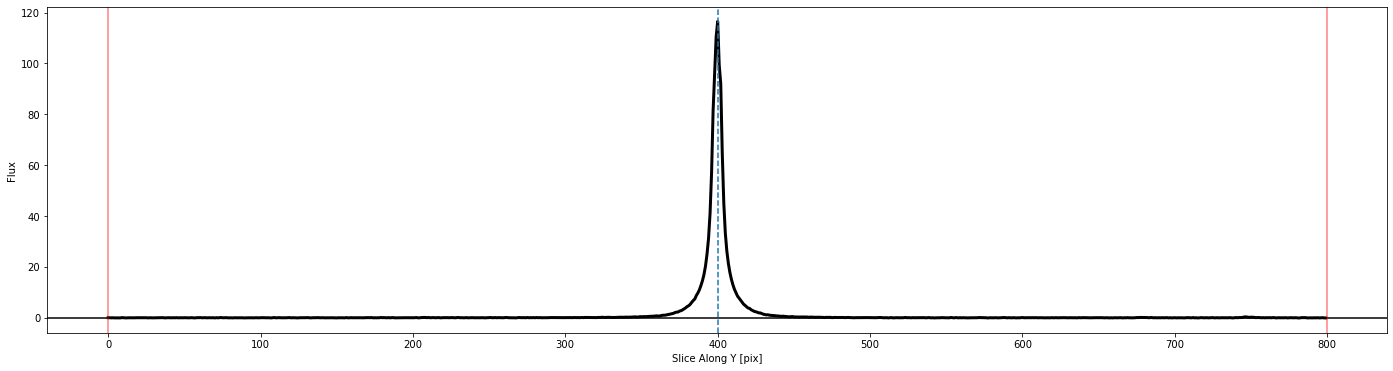

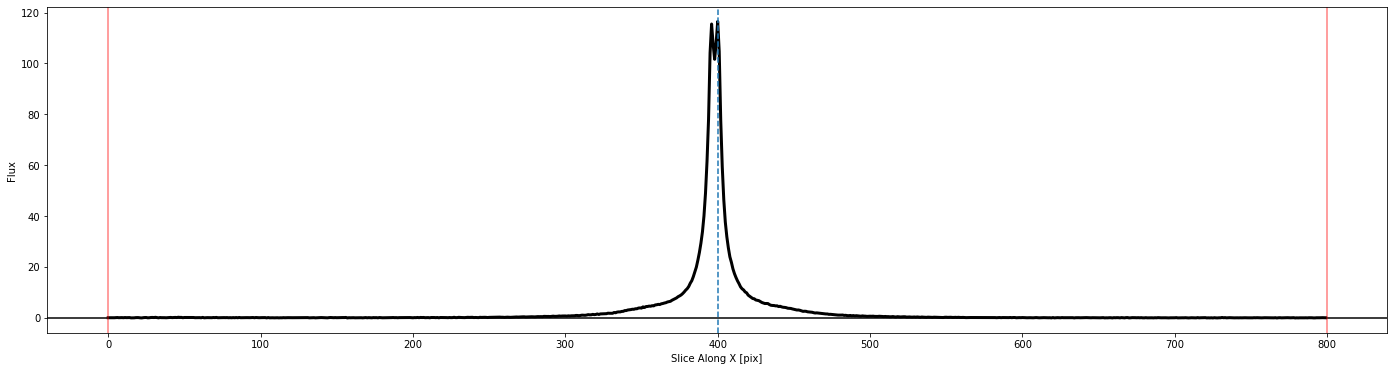

In [187]:
from petrofit.photometry import source_photometry

# Photomerty
flux_arr, area_arr, error_arr = source_photometry(

    # Inputs
    source, # Source (`photutils.segmentation.catalog.SourceCatalog`)
    image.data, # Image as 2D array
    segm_deblend, # Deblended segmentation map of image
    r_list, # list of aperture radii

    # Options
    cutout_size=2*max(r_list), # Cutout out size, set to double the max radius
    bkg_sub=True, # Subtract background
    sigma=3, sigma_type='clip', # Fit a 2D plane to pixels within 3 sigma of the mean
    plot=True, vmax=vmax, vmin=vmin, # Show plot with max and min defined above
)
plt.show()

In [188]:
from astropy.table import Table

t = Table(
    data=[r_list, flux_arr, area_arr, error_arr],
    names=['r_list', 'flux_arr', 'area_arr', 'error_arr'],
)

t.write('sampel_galaxy.csv', overwrite=True)

t[:10]

r_list,flux_arr,area_arr,error_arr
float64,float64,float64,float64
8.0,4028.649006,54.510014,nan
16.0,9877.622325,218.040057,nan
24.0,14725.694141,490.590129,nan
32.0,19040.9125,872.160229,nan
40.0,23105.90426,1362.750359,nan
48.0,27029.580059,1962.360516,nan
56.0,30844.065922,2670.990703,nan
64.0,34473.397706,3488.640918,nan
72.0,37797.14238,4415.311162,nan


In [189]:
from petrofit.petrosian import Petrosian

p = Petrosian(r_list, area_arr, flux_arr)

In [190]:
p.r_petrosian # in pixels

141.46829365873177

In [196]:
p.total_flux 

64366.435252081734

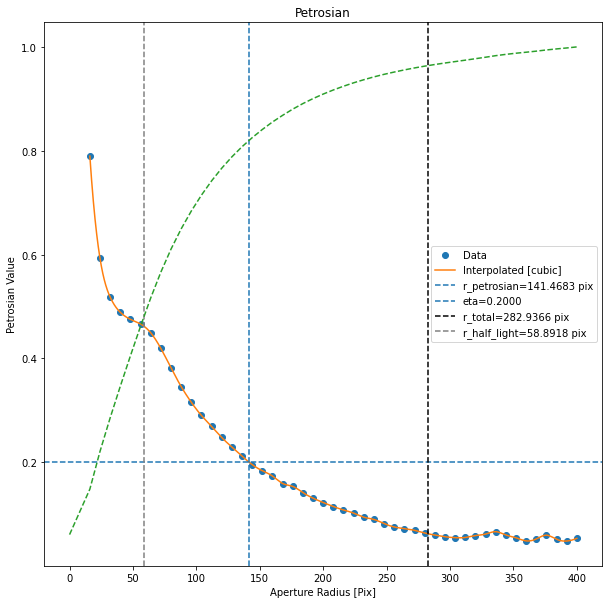

In [192]:
p.plot(plot_r=True, plot_normalized_flux=True)
plt.show()

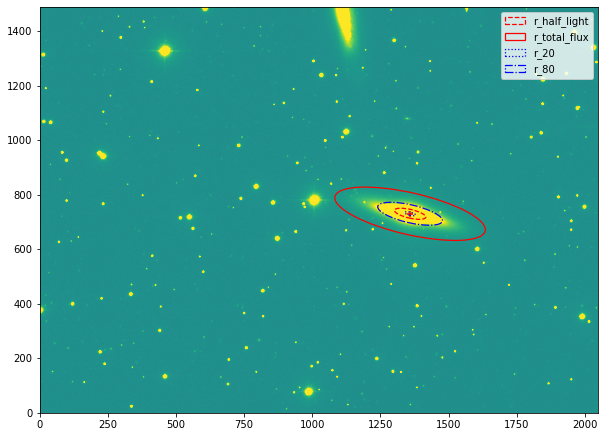

In [193]:
from petrofit.segmentation import get_source_position, get_source_elong, get_source_theta

position = get_source_position(source)
elong = get_source_elong(source)
theta = get_source_theta(source)

p.imshow(position=position, elong=elong, theta=theta, lw=1.25)

plt.imshow(image.data, vmax=vmax, vmin=vmin)

plt.legend()
plt.show()